## Evolutional optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from moebius import olr
import traceback
import sys
import time

In [2]:
from typing import Optional, Union, List, Tuple
from golem.core.optimisers.graph import OptGraph, OptNode
from golem.core.optimisers.objective import Objective, ObjectiveEvaluate
from golem.core.optimisers.optimization_parameters import GraphRequirements
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from golem.core.optimisers.genetic.operators.selection import SelectionTypesEnum
from golem.core.optimisers.optimizer import GraphGenerationParams
from golem.core.adapter import DirectAdapter
from golem.core.optimisers.genetic.gp_optimizer import EvoGraphOptimizer

from golem.core.dag.graph_delegate import GraphDelegate
from golem.core.dag.linked_graph_node import LinkedGraphNode
from golem.core.dag.linked_graph import LinkedGraph

from golem.core.log import Log
import logging

from datetime import timedelta

class GMMModel(GraphDelegate):
    def __init__(self, nodes: Optional[Union[LinkedGraphNode, List[LinkedGraphNode]]] = None):
        super().__init__(nodes)
        self.unique_pipeline_id = 1
    
    def find_node(self, name: str) -> Union[LinkedGraphNode, None]:
        for node in self.nodes:
            if node.content['name'] == name:
                return node
        
        return None

In [3]:
from golem.core.optimisers.graph import OptNode
from golem.core.dag.linked_graph_node import LinkedGraphNode

class GMMNode(LinkedGraphNode):
    def __str__(self):
        return self.content["name"]

In [4]:
from abc import ABC, abstractmethod
from random import choice, random, randint, uniform

class MutationStrategy(ABC):
    @abstractmethod
    def __call__(self, graph: GMMModel, **kwargs) -> GMMModel:
        pass

class SimpleMutationStrategy(MutationStrategy):
    def __init__(self, key: str):
        self.__key = key
    
    @abstractmethod
    def _mutate(self, val: float) -> float:
        pass
    
    def __call__(self, graph: GMMModel, **kwargs) -> GMMModel:
        node = choice(graph.nodes)
        node.content[self.__key] = self._mutate(node.content[self.__key])
        
        return graph

class RandomIntFromIntervalMutationStrategy(SimpleMutationStrategy):
    def __init__(self, key: str, bounds: Tuple[int, int]):
        super().__init__(key)
        self.__bounds = bounds
    
    def _mutate(self, val: float) -> float:
        l, r = self.__bounds
        
        return randint(l, r)
        
class RandomUniformFromIntervalMutationStrategy(SimpleMutationStrategy):
    def __init__(self, key: str, bounds: Tuple[float, float]):
        super().__init__(key)
        self.__bounds = bounds
    
    def _mutate(self, val: float) -> float:
        l, r = self.__bounds
        
        return uniform(l, r)
        
class RandomUniformDeltaMutationStrategy(SimpleMutationStrategy):
    def __init__(self, key: str, bounds: Tuple[float, float]):
        super().__init__(key)
        self.__bounds = bounds
    
    def _mutate(self, val: float) -> float:
        l, r = self.__bounds
        
        return val + uniform(l, r)

class WrapNegativeValueMutationStrategy(MutationStrategy):
    def __init__(self, key: str, bounds: Tuple[float, float], decorable: MutationStrategy):
        self.__key = key
        self.__bounds = bounds
        self.__decorable = decorable
    
    def __call__(self, graph: GMMModel, **kwargs) -> GMMModel:
        graph = self.__decorable(graph, **kwargs)
        
        for i, node in enumerate(graph.nodes):
            val = node.content[self.__key]
            
            if val < 0:
                node.content[self.__key] = np.random.uniform(self.__bounds[0], self.__bounds[1])
        
        return graph
    
class GMMWeightsMutationStrategy(MutationStrategy):
    def __init__(self, key: str):
        self.__key = key
    
    def __call__(self, graph: GMMModel, **kwargs) -> GMMModel:        
        array = np.random.random(len(graph.nodes))
        array /= np.sum(array)
        
        for i, node in enumerate(graph.nodes):
            node.content[self.__key] = array[i]
        
        return graph

In [5]:
class CrossoverStrategy(ABC):
    @abstractmethod
    def __call__(self, g1: GMMModel, g2: GMMModel, **kwargs) -> (GMMModel, GMMModel):
        pass

class ExchangeCrossoverStrategy(CrossoverStrategy):
    def __init__(self, key: str):
        self.__key = key
    
    def __call__(self, g1: GMMModel, g2: GMMModel, **kwargs) -> (GMMModel, GMMModel):
        node1 = choice(g1.nodes)
        node2 = choice(g2.nodes)
        node1.content[self.__key], node2.content[self.__key] = node2.content[self.__key], node1.content[self.__key]
    
        return g1, g2

In [6]:
from math import factorial

class GMMParameters:
    def __init__(self, w: float, mean: float, var: float):
        self.w = w
        self.mean = mean
        self.var = var

class GMMSetup:
    def __init__(self, components: list[GMMParameters], target_olrs: tuple[float, ...], target_olr: float):
        target_olrs_len = len(target_olrs)
        components_len = len(components)
        combinations = GMMSetup.combinations(components_len, 2)
        if target_olrs_len != combinations:
            b = "\\"
            raise ValueError(f'Illegal length of target_olrs received. It must be C^{b}2{b}_{b}{components_len}{b} = {combinations}, but {target_olrs_len} given.')
        
        self.components = components
        self.target_olrs = target_olrs
        self.target_olr = target_olr
    
    def combinations(n: int, k: int) -> int:
        if n < k:
            raise ValueError('k cannot be greater than n')
        
        return int(factorial(n) / (factorial(k) * factorial(n - k)))

class GMMOptimizerParameters:
    init: GMMSetup
    generations: int = 100
    population_size: int = 30
    timeout: int = 10
        
    crossover_prob: float = 0.8 
    mutation_prob: float = 0.9
    
    def __init__(self, init: GMMSetup):
        self.init = init
    
    def components(self) -> list[GMMParameters]:
        return self.init.components
    
    def components_len(self) -> int:
        return len(self.init.components)

class GMMOptimizer(ABC):
    def __init__(self, params: GMMOptimizerParameters):
        self.__params = params
        self.__objective = Objective({'custom': self._metric})
        self.__objective_eval = ObjectiveEvaluate(self.__objective)
        self.optimizer = self.__create_optimizer()
    
    def _has_no_equal_mean(self, graph):
        mean= []
        for node in graph.nodes:
            mean.append(node.content['mean'])
        mean_new = list(dict.fromkeys(mean))
        if len(mean) != len(mean_new):
            raise ValueError('Custom graph has duplicates')
        return True
    
#     def _cov_is_positive_semidefined(self, graph):
#         for node in graph.nodes:
#             if node.content['var'] < 0:
#                 node.content['var'] = np.random.uniform(0.1, 10)
        
#         return True
    
    def _metric(self, gmm: GMMModel):
        w = []
        mean = []
        var = []
        
        for i in range(self.__params.components_len()):
            j = i + 1
            
            node = gmm.find_node(f'Comp_{j}')
            w.append(node.content['w'])
            mean.append([node.content['mean']])
            var.append([[node.content['var']]])
        
        
        
        try:
            o = olr(w, mean, var)
            
            d = (sum(o) / len(o) - self.__params.init.target_olr) ** 2
            
#             print('diff: ' + str(d) + '; olr: ' + str(o) + '; ', w, mean, var)
            
            return d
            
#             return np.sum(np.subtract(olr(w, mean, var), self.__params.init.target_olrs) ** 2)
        except:
            print('Error message')
    
    def __create_optimizer(self):
        initial = [
            GMMModel(
                nodes=[
                    GMMNode(
                        nodes_from=None,
                        content={
                            'name': 'Comp_' + str(i + 1),
                            'w': comp.w,
                            'mean': comp.mean,
                            'var': comp.var
                        }
                    )
                    for i, comp in enumerate(self.__params.init.components)
                ]
            )
        ]
        
        requirements = GraphRequirements(
            max_arity=100,
            max_depth=100, 
            early_stopping_iterations=6,
            num_of_generations=self.__params.generations,
            timeout=timedelta(minutes=self.__params.timeout),
            history_dir = None,
            n_jobs=-1
        )
        
        optimiser_parameters = GPAlgorithmParameters(
            pop_size=self.__params.population_size,
            crossover_prob=self.__params.crossover_prob, 
            mutation_prob=self.__params.mutation_prob,
            genetic_scheme_type = GeneticSchemeTypesEnum.steady_state,
            selection_types = [SelectionTypesEnum.tournament],
            mutation_types = [
                GMMWeightsMutationStrategy('w'),
                RandomUniformDeltaMutationStrategy('mean', (-20, 20)),
                WrapNegativeValueMutationStrategy(
                    'var',
                    (1, 10),
                    RandomUniformDeltaMutationStrategy('var', (-0.1, 0.1))
                )
            ],
            crossover_types = [
                ExchangeCrossoverStrategy('w'),
                ExchangeCrossoverStrategy('mean'),
                ExchangeCrossoverStrategy('var')
            ]
        )
        rules = [self._has_no_equal_mean]
        graph_generation_params = GraphGenerationParams(
            adapter=DirectAdapter(base_graph_class=GMMModel, base_node_class=GMMNode),
            rules_for_constraint=rules
        )
        
        return EvoGraphOptimizer(
            graph_generation_params=graph_generation_params,
            graph_optimizer_params=optimiser_parameters,
            requirements=requirements,
            initial_graphs=initial,
            objective=self.__objective
        )
    
    def optimize(self):
        return self.optimizer.optimise(self.__objective_eval)[0]

In [7]:
# setup = GMMSetup(
#     [
#         GMMParameters(1 / 3, 12, 0.5),
#         GMMParameters(1 / 3, 6, 0.5),
#         GMMParameters(1 / 3, 10, 0.5)
#     ],
#     [
#         0.4,
#         0.8,
#         0.2
#     ],
#     0.5
# )

# optimizer = GMMOptimizer(GMMOptimizerParameters(setup))
# # res = optimizer.optimize()

In [8]:
# for node in res.nodes:    
#     print(node.content['name'] + ' (w: ' + str(round(node.content['w'], 4)) + ', mean: ' + str(round(node.content['mean'], 4)) + ', var: ' + str(round(node.content['var'], 4)) + ')')

# w = []
# mean = []
# var = []

# for node in res.nodes:
#     w.append(node.content['w'])
#     mean.append([node.content['mean']])
#     var.append([[node.content['var']]])

# olr(w, mean, var)

In [9]:
# optimizer.optimizer._history.show()

In [10]:
class VoidLoggerAdapter:
    def debug(self, msg, *args, **kwargs):
        pass

    def info(self, msg, *args, **kwargs):
        pass

    def warning(self, msg, *args, **kwargs):
        pass

    def error(self, msg, *args, **kwargs):
        pass

    def exception(self, msg, *args, exc_info=True, **kwargs):
        pass

    def critical(self, msg, *args, **kwargs):
        pass

    def log(self, level, msg, *args, **kwargs):
        pass

    def message(self, msg: str, **kwargs):
        pass

In [11]:
def benchmark(comps):
    result = []
    
#     for target_olr in [0.2, 0.4, 0.6, 0.8]:
    
    for i in range(20):
        weights = np.random.random(comps)
        weights /= np.sum(weights)
        
        initial_values = []
        for i in range(comps):
            initial_values.append(GMMParameters(weights[i], np.random.randint(0, 12), np.random.uniform(0.1, 5.0)))

        olrs = np.random.random(GMMSetup.combinations(comps, 2))

        setup = GMMSetup(
            initial_values,
            olrs,
            0.6
        )
        
        params = GMMOptimizerParameters(setup)
        params.population_size = 50

        optimizer = GMMOptimizer(params)
        optimizer.optimizer.log = VoidLoggerAdapter()

        start = time.process_time()
        
        res = optimizer.optimize()
        
        elapsed = (time.process_time() - start)

        w0 = []
        mean0 = []
        var0 = []

        for node0 in res.nodes:
            w0.append(node0.content['w'])
            mean0.append([node0.content['mean']])
            var0.append([[node0.content['var']]])

#         print('comps: ' + str(comps) + ', curr: (' + ', '.join([str(x) for x in olr(w0, mean0, var0)]) + '), need: (' + ', '.join([str(x) for x in olrs]) + ')')

        o = olr(w0, mean0, var0)
        
        print('comps: ' + str(comps) + ', avg: ' + str(sum(o) / len(o)))
    
#         result.append(sum(o) / len(o))

#         result.append([x - olrs[i] for i, x in enumerate(olr(w0, mean0, var0))])
    
        result.append(elapsed)
    
    return result

In [12]:
# comps = 2
# weights = np.random.random(comps)
# weights /= np.sum(weights)
        
# initial_values = []
# for i in range(comps):
#     initial_values.append(GMMParameters(weights[i], np.random.randint(0, 12), np.random.uniform(0.1, 5.0)))

# olrs = np.random.random(GMMSetup.combinations(comps, 2))

# setup = GMMSetup(
#     initial_values,
#     olrs,
#     0.6
# )
        
# params = GMMOptimizerParameters(setup)
# params.population_size = 50

# optimizer = GMMOptimizer(params)
# optimizer.optimizer.log = VoidLoggerAdapter()

# res = optimizer.optimize()

In [13]:
# plt.rcParams['figure.dpi'] = 250

# optimizer.optimizer._history.show()

In [14]:
# min(optimizer.optimizer._history.historical_fitness[26])

In [15]:
# from gmr import GMM
# from scipy.stats import norm

# # weights = [0.44774828528155547, 0.5522517147184446]
# # means = [[7], [0]]
# # covs = [[[4.1674762110279975]], [[0.8980901624099956]]]

# # gmm1 = GMM(2, priors=weights, means=means, covariances=covs)

# # weights = [0.44774828528155547, 0.5522517147184446]
# # means = [[4.015289377611001], [0]]
# # covs = [[[4.1674762110279975]], [[0.8980901624099956]]]

# # gmm2 = GMM(2, priors=weights, means=means, covariances=covs)

# weights = [0.3514470010257941, 0.6485529989742059]
# means = [[7], [0]]
# covs = [[[4.11805722210562]], [[4.158763194763159]]]

# gmm3 = GMM(2, priors=weights, means=means, covariances=covs)

In [16]:
# # X1 = gmm1.sample(1000)
# # X2 = gmm2.sample(1000)
# X3 = gmm3.sample(1000)

In [17]:
# plt.rcParams['figure.dpi'] = 150

# x_axis = np.arange(-3, 14, 0.01)
# plt.hist(X3, bins=40, color='#fdbf6f', density=True)
# plt.plot(x_axis, norm.pdf(x_axis, means[0][0], covs[0][0][0]) * weights[0], color='#33a02c')
# plt.plot(x_axis, norm.pdf(x_axis, means[1][0], covs[1][0][0]) * weights[1], color='#1f78b4')
# plt.title('OLR = 0.6', fontsize = 20)

# frame1 = plt.gca()
# for xlabel_i in frame1.axes.get_xticklabels():
#     xlabel_i.set_visible(False)
# for ylabel_i in frame1.axes.get_yticklabels():
#     ylabel_i.set_visible(False)

# figure = plt.gcf()
# figure.patch.set_alpha(0.0)

# plt.show()

In [18]:
# olrs = []

# for comps in range(2, 11):
#     olrs.append(benchmark(comps))

In [19]:
# # olrs_1 = olrs
# olrs_2 = olrs

In [20]:
# len(olrs_1[5])

In [21]:
# olrs_deviations = [[sum(o_i) for o_i in o] for o in olrs_1]

In [22]:
# olrs_deviations = [[o_i - 0.6 for o_i in o] for o in olrs_1]

In [23]:
# plt.rcParams['figure.dpi'] = 250

# fig = plt.figure(figsize =(10, 4))
# ax = fig.add_axes([0, 0, 1, 1])

# bp = ax.boxplot(olrs_2, positions=range(2, 11), patch_artist=True, medianprops=dict(color='#e31a1c'))
# for patch in bp['boxes']:
#     patch.set_facecolor('#fdbf6f')

# ax.set_xlabel('Components')
# ax.set_ylabel('Time (s)')

# # ax2 = ax.twiny()
# # ax2.set_xticks(ax.get_xticks())
# # ax2.set_xbound(ax.get_xbound())
# # ax2.set_xticklabels([GMMSetup.combinations(x, 2) for x in ax.get_xticks()])
# # ax2.set_xlabel(r"Number of OLRs = $C^2_n$")

# plt.savefig('evol_boxplot.png', format='png')
# plt.show()

In [24]:
# comps = 2
# weights = np.random.random(comps)
# weights /= np.sum(weights)
        
# initial_values = []
# for i in range(comps):
#     initial_values.append(GMMParameters(weights[i], np.random.randint(0, 12), np.random.uniform(0.1, 5.0)))

# olrs = np.random.random(GMMSetup.combinations(comps, 2))

# setup = GMMSetup(
#     initial_values,
#     olrs,
#     0.6
# )
        
# params = GMMOptimizerParameters(setup)
# params.population_size = 50

# optimizer = GMMOptimizer(params)
# optimizer.optimizer.log = VoidLoggerAdapter()

# res = optimizer.optimize()

In [25]:
# weights = []
# means = []
# covs = []

# for node in res.nodes:
#     weights.append(node.content['w'])
#     means.append([node.content['mean']])
#     covs.append([[node.content['var']]])

# gmm = GMM(2, priors=weights, means=means, covariances=covs)

In [26]:
# X = gmm.sample(1000)

In [27]:
# plt.rcParams['figure.dpi'] = 150

# x_axis = np.arange(-6, 7, 0.01)
# plt.hist(X, bins=40, color='#fdbf6f', density=True)
# plt.plot(x_axis, norm.pdf(x_axis, means[0][0], covs[0][0][0]) * weights[0], color='#33a02c')
# plt.plot(x_axis, norm.pdf(x_axis, means[1][0], covs[1][0][0]) * weights[1], color='#1f78b4')
# # plt.title('OLR = 0.6', fontsize = 20)

# # frame1 = plt.gca()
# # for xlabel_i in frame1.axes.get_xticklabels():
# #     xlabel_i.set_visible(False)
# # for ylabel_i in frame1.axes.get_yticklabels():
# #     ylabel_i.set_visible(False)

# figure = plt.gcf()
# figure.patch.set_alpha(0.0)

# plt.box(False)
# plt.xticks([])
# plt.yticks([])
# plt.show()

## Bayessian network

In [28]:
import pandas as pd

from sklearn import preprocessing
from scipy.stats import norm

from gmr import GMM, plot_error_ellipses

import bamt
from bamt.networks.continuous_bn import ContinuousBN
from bamt.networks.hybrid_bn import HybridBN
import bamt.preprocessors as pp
from bamt.utils.MathUtils import component
from pgmpy.estimators import K2Score

from sklearn.mixture import GaussianMixture

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def next_parameters(comps, target_olr):
    weights = np.random.random(comps)
    weights /= np.sum(weights)

    initial_values = []

    for i in range(comps):
        initial_values.append(GMMParameters(weights[i], np.random.randint(-24, 24), np.random.uniform(0.1, 10.0)))
    olrs = np.random.random(GMMSetup.combinations(comps, 2))

    setup = GMMSetup(
        initial_values,
        olrs,
        target_olr
    )

    optimizer = GMMOptimizer(GMMOptimizerParameters(setup))
    optimizer.optimizer.log = VoidLoggerAdapter()

    res = optimizer.optimize()

    w0 = []
    mean0 = []
    var0 = []

    for node0 in res.nodes:
        w0.append(node0.content['w'])
        mean0.append([node0.content['mean']])
        var0.append([[node0.content['var']]])

    return w0, mean0, var0

def multi_dims(dims, comps, target_olr):
    Xs = []
    
    # 1. Попробовать использовать одинаковые параметры для каждого измерения
    # 2. Варьировать диапазоны значений среднего / диспресии эвольционного алгоритма
    # 3. Попробовать варьировать таргетный OLR
    
    w0, mean0, var0 = next_parameters(comps, target_olr)
        
    if sum(w0) != 1:
        w0_diff = sum(w0) - 1
        for i in range(len(w0)):
            w0[i] -= w0_diff / len(w0)
    
    for dim in range(dims):
        gmm = GMM(comps, priors=w0, means=mean0, covariances=var0)
        X = gmm.sample(1000)
        Xs.append(X)
    
    return pd.DataFrame(np.stack(Xs, axis=1)[:, :, 0], columns=['X' + str(i + 1) for i in range(len(Xs))])

In [30]:
# df = multi_dims(3, 2, 0.3)

In [31]:
def sample_by_structure(df, structure, possible_nodes = ['X1', 'X2', 'X3']):
    bn_sample_olrs = []

    encoder = preprocessing.LabelEncoder()
    discretizer = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

    p = pp.Preprocessor([('discretizer', discretizer)])
    discretized_data, est = p.apply(df)

    bn = ContinuousBN(use_mixture=True)

    bn.add_nodes(p.info)
    bn.set_structure(edges = structure)

    bn.fit_parameters(df)

    #p.info['signs']['X1'] = 'neg'

    for i in range(30):
        sample = bn.sample(1000)
        
        gmm = GaussianMixture(n_components=component(df, possible_nodes, 'bic'), random_state=0)
        gmm.fit(sample.to_numpy())

        w0 = gmm.weights_.tolist()
        mean0 = gmm.means_.tolist()
        cov0 = gmm.covariances_.tolist()

        def make_diagonal(matrix):
            for i in range(len(matrix)):
                for j in range(i, len(matrix[0])):
                    matrix[j][i] = matrix[i][j]

            return matrix

    #     print('Before ' + str(cov0))

        for i in range(len(cov0)):
            cov0[i] = make_diagonal(cov0[i])

    #     print('After ' + str(cov0))

        o = olr(w0, mean0, cov0)
#         print(o)

        bn_sample_olrs.append(o)
        
    return bn_sample_olrs

In [32]:
def do_brute_force_graph():
    possible_nodes = ['X1', 'X2', 'X3']

    for _ in range(2):
        edges = []

        for start in possible_nodes:
            for end in possible_nodes:
                if start != end:
                    yield (start, end)

In [33]:
def brute_force_graph():
    res = []

    for a in do_brute_force_graph():
        for b in do_brute_force_graph():
            if a == b:
                continue

            n = ['X1', 'X2', 'X3']

            for each in a + b:
                if each in n:
                    n.remove(each)

            if len(n) == 0:
                node = [a, b]
                rev_node = [b, a]

                if node not in res and rev_node not in res:
                    res.append(node)

    return res

In [34]:
# to_plot = {}

# for node in brute_force_graph():
#     x = sample_by_structure(df, node)
    
#     to_plot[str(node)] = x

### 0.3

In [35]:
# for k, v in to_plot.items():    
#     plt.plot([sum(v_i) / len(v_i) for v_i in v])
#     plt.title(str(k))
#     plt.plot([0, 100], [0.3, 0.3])
#     plt.show()

### 0.6

In [36]:
# df_0_6 = multi_dims(3, 2, 0.6)

In [37]:
# to_plot_0_6 = {}

# for node in brute_force_graph():
#     x = sample_by_structure(df_0_6, node)
    
#     to_plot_0_6[str(node)] = x

In [38]:
# for k, v in to_plot_0_6.items():    
#     plt.plot([sum(v_i) / len(v_i) for v_i in v])
#     plt.title(str(k))
#     plt.plot([0, 100], [0.6, 0.6])
#     plt.show()

### 0.9

In [39]:
# df_0_9 = multi_dims(3, 2, 0.9)

In [40]:
# to_plot_0_9 = {}

# for node in brute_force_graph():
#     x = sample_by_structure(df_0_9, node)
    
#     to_plot_0_9[str(node)] = x

In [41]:
# for k, v in to_plot_0_9.items():    
#     plt.plot([sum(v_i) / len(v_i) for v_i in v])
#     plt.title(str(k))
#     plt.plot([0, 100], [0.9, 0.9])
#     plt.show()

### ---

In [42]:
# gmm = GMM(n_components=2, random_state=0)
# gmm.from_samples(df.to_numpy())

# w0 = gmm.priors.tolist()
# mean0 = gmm.means.tolist()
# cov0 = gmm.covariances.tolist()

# def make_diagonal(matrix):
#     for i in range(len(matrix)):
#         for j in range(i, len(matrix[0])):
#             matrix[j][i] = matrix[i][j]

#     return matrix


# for i in range(len(cov0)):
#     cov0[i] = make_diagonal(cov0[i])

# print(olr(w0, mean0, cov0))

In [43]:
# encoder = preprocessing.LabelEncoder()
# discretizer = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

# p = pp.Preprocessor([('discretizer', discretizer)])
# discretized_data, est = p.apply(df)

# bn = ContinuousBN(use_mixture=True)

# bn.add_nodes(p.info)
# bn.set_structure(edges = [('X1', 'X2'), ('X2', 'X3')])

# bn.fit_parameters(df)

In [44]:
# bn.get_info()

In [45]:
# sample = bn.sample(1000)

In [46]:
# gmm = GMM(n_components=2, random_state=0)
# gmm.from_samples(sample.to_numpy())

# w0 = gmm.priors.tolist()
# mean0 = gmm.means.tolist()
# cov0 = gmm.covariances.tolist()

In [47]:
# def make_diagonal(matrix):
#     for i in range(len(matrix)):
#         for j in range(i, len(matrix[0])):
#             matrix[j][i] = matrix[i][j]

#     return matrix

# for i in range(len(cov0)):
#     cov0[i] = make_diagonal(cov0[i])

# print(olr(w0, mean0, cov0))

In [48]:
# plt.hist(df['X1'])
# plt.hist(sample['X1'], fc=(0, 0, 0, 0.5))

In [49]:
# from bamt.utils.MathUtils import component

In [50]:
# component(df, ['X1', 'X2', 'X3'], 'bic')

## ---

In [51]:
import networkx as nx

In [52]:
target_olr = 0.3
number_of_atr = 3
p = [0.1, 0.5, 0.8]
to_plot = {}
for dimensions in range(2, 9):
    df = multi_dims(dimensions, number_of_atr, target_olr)
    for p_i in p:
        G = []
        is_all = True
        while is_all == True:
            G=nx.gnp_random_graph(dimensions,p_i,directed=True)
            G = nx.DiGraph([(u,v) for (u,v) in G.edges() if u<v])
            if len(G.nodes) == dimensions:
                is_all = False
        for layer, nodes in enumerate(nx.topological_generations(G)):
            for node in nodes:
                G.nodes[node]["layer"] = layer

        possible_nodes = ['X' + str(x + 1) for x in range(dimensions)]
#         print(possible_nodes)
        structure = [('X' + str(edge[0] + 1), 'X' + str(edge[1] + 1)) for edge in G.edges]
#         print(structure)

        if dimensions not in to_plot:
            to_plot[dimensions] = []

        to_plot[dimensions].append({
            'p': p_i,
            'olrs': sample_by_structure(df, structure, possible_nodes)
        })
        
        print(dimensions, p_i)
        
#         print(structure)

Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

2023-09-14 10:13:53,357 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:13:54,240 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:13:54,395 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:13:54,396 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:13:54,406 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:13:55,653 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:13:55,671 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:13:56,397 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:13:56,420 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:13:57,201 - MultiprocessingDispatcher - 54 individuals out of 54 in previous

Generations:   1%|          | 1/100 [00:22<?, ?gen/s]

2023-09-14 10:14:16,265 - OptimisationTimer - Composition time: 0.382 min
2023-09-14 10:14:16,269 | INFO     | preprocessors.py-scan-0099 | No one column is discrete



100%|██████████| 1000/1000 [00:00<00:00, 2136.57it/s]


2 0.1
2023-09-14 10:14:34,924 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:00<00:00, 2120.26it/s]


2 0.5
2023-09-14 10:14:53,304 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:00<00:00, 2152.03it/s]


2 0.8


Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

2023-09-14 10:15:11,573 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:15:11,618 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:15:11,784 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:15:11,785 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:15:11,795 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:15:12,539 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:15:12,559 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:15:13,287 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:15:13,307 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:15:14,073 - MultiprocessingDispatcher - 54 individuals out of 54 in previous

Generations:   1%|          | 1/100 [00:10<?, ?gen/s]

2023-09-14 10:15:21,694 - OptimisationTimer - Composition time: 0.169 min
2023-09-14 10:15:21,697 | INFO     | preprocessors.py-scan-0099 | No one column is discrete



100%|██████████| 1000/1000 [00:00<00:00, 1462.40it/s]


3 0.1
2023-09-14 10:15:46,269 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:00<00:00, 1112.49it/s]


3 0.5
2023-09-14 10:16:17,560 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:00<00:00, 1098.79it/s]


3 0.8


Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

2023-09-14 10:16:48,800 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:16:48,842 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:16:49,007 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:16:49,008 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:16:49,018 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:16:49,738 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:16:49,754 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:16:50,498 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:16:50,518 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:16:51,246 - MultiprocessingDispatcher - 54 individuals out of 54 in previous

Generations:   1%|          | 1/100 [00:24<?, ?gen/s]

2023-09-14 10:17:13,065 - OptimisationTimer - Composition time: 0.404 min
2023-09-14 10:17:13,069 | INFO     | preprocessors.py-scan-0099 | No one column is discrete



100%|██████████| 1000/1000 [00:01<00:00, 618.45it/s]


4 0.1
2023-09-14 10:18:08,510 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:01<00:00, 639.55it/s]


4 0.5
2023-09-14 10:19:01,977 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:01<00:00, 616.75it/s]


4 0.8


Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

2023-09-14 10:19:57,080 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:19:57,123 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:19:57,279 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:19:57,280 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:19:57,289 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:19:58,026 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:19:58,044 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:19:58,795 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:19:58,814 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:19:59,551 - MultiprocessingDispatcher - 54 individuals out of 54 in previous

Generations:   1%|          | 1/100 [00:19<?, ?gen/s]

2023-09-14 10:20:16,932 - OptimisationTimer - Composition time: 0.331 min
2023-09-14 10:20:16,935 | INFO     | preprocessors.py-scan-0099 | No one column is discrete



100%|██████████| 1000/1000 [00:01<00:00, 736.06it/s]


5 0.1
2023-09-14 10:21:04,800 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:01<00:00, 691.50it/s]


5 0.5
2023-09-14 10:21:54,874 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:01<00:00, 524.43it/s]


5 0.8


Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

2023-09-14 10:22:59,396 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:22:59,440 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:22:59,595 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:22:59,596 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:22:59,606 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:23:00,298 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:23:00,315 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:23:01,064 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:23:01,085 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:23:01,866 - MultiprocessingDispatcher - 54 individuals out of 54 in previous

Generations:   1%|          | 1/100 [00:25<?, ?gen/s]

2023-09-14 10:23:24,501 - OptimisationTimer - Composition time: 0.418 min
2023-09-14 10:23:24,504 | INFO     | preprocessors.py-scan-0099 | No one column is discrete



100%|██████████| 1000/1000 [00:01<00:00, 707.14it/s]


6 0.1
2023-09-14 10:24:14,060 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:02<00:00, 423.66it/s]


6 0.5
2023-09-14 10:25:32,685 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:02<00:00, 398.41it/s]


6 0.8


Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

2023-09-14 10:26:55,486 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:26:55,531 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:26:56,247 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:26:56,248 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:26:56,289 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:26:56,982 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:26:57,024 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:26:57,752 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:26:57,775 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:26:58,504 - MultiprocessingDispatcher - 54 individuals out of 54 in previous

Generations:   1%|          | 1/100 [00:07<?, ?gen/s]

2023-09-14 10:27:03,424 - OptimisationTimer - Composition time: 0.132 min
2023-09-14 10:27:03,430 | INFO     | preprocessors.py-scan-0099 | No one column is discrete



100%|██████████| 1000/1000 [00:02<00:00, 495.56it/s]


7 0.1
2023-09-14 10:28:17,433 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:02<00:00, 426.40it/s]


7 0.5
2023-09-14 10:29:40,615 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:03<00:00, 311.79it/s]


7 0.8


Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

2023-09-14 10:31:29,730 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:31:29,774 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:31:29,934 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:31:29,935 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-09-14 10:31:29,944 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:31:30,671 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:31:30,694 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:31:31,420 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-09-14 10:31:31,441 - MultiprocessingDispatcher - Number of used CPU's: 4
2023-09-14 10:31:32,171 - MultiprocessingDispatcher - 54 individuals out of 54 in previous

Generations:   1%|          | 1/100 [00:13<?, ?gen/s]

2023-09-14 10:31:43,698 - OptimisationTimer - Composition time: 0.233 min
2023-09-14 10:31:43,702 | INFO     | preprocessors.py-scan-0099 | No one column is discrete



100%|██████████| 1000/1000 [00:02<00:00, 429.51it/s]


8 0.1
2023-09-14 10:33:08,659 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:04<00:00, 242.37it/s]


8 0.5
2023-09-14 10:35:28,911 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:04<00:00, 226.80it/s]


8 0.8


In [53]:
data_0_1 = []
data_0_5 = []
data_0_8 = []

for (n_comps, objs) in to_plot.items():
    for obj in objs:
        prob = obj['p']
        olrs = obj['olrs']
        
        if prob == 0.1:
            data_0_1.append([sum(o) / len(o) - target_olr for o in olrs])
        
        if prob == 0.5:
            data_0_5.append([sum(o) / len(o) - target_olr for o in olrs])
        
        if prob == 0.8:
            data_0_8.append([sum(o) / len(o) - target_olr for o in olrs])

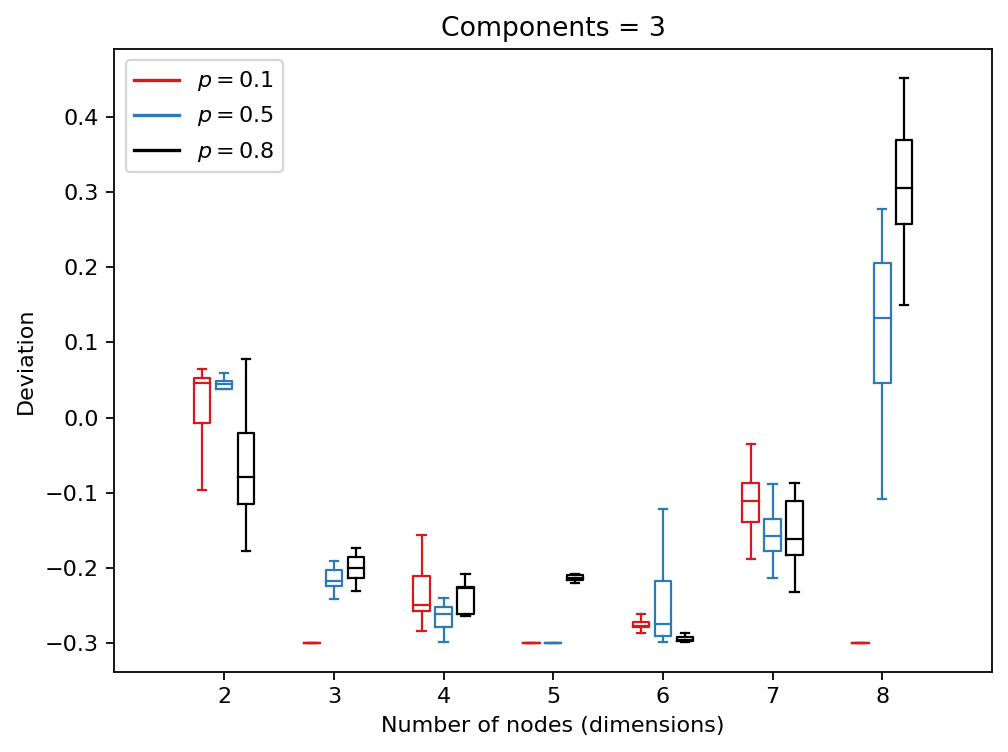

In [54]:
ticks = [x[0] for x in to_plot.items()]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.rcParams['figure.dpi'] = 160
plt.figure()

bp_0_1 = plt.boxplot(data_0_1, positions=np.array(range(len(data_0_1)))*2.0-0.4, sym='', widths=0.3)
bp_0_5 = plt.boxplot(data_0_5, positions=np.array(range(len(data_0_5)))*2.0, sym='', widths=0.3)
bp_0_8 = plt.boxplot(data_0_8, positions=np.array(range(len(data_0_5)))*2.0+0.4, sym='', widths=0.3)
set_box_color(bp_0_1, '#D7191C')
set_box_color(bp_0_5, '#2C7BB6')
set_box_color(bp_0_8, 'black')

plt.plot([], c='#D7191C', label='$p = 0.1$')
plt.plot([], c='#2C7BB6', label='$p = 0.5$')
plt.plot([], c='black', label='$p = 0.8$')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.xlabel('Number of nodes (dimensions)')
plt.ylabel('Deviation')
plt.title('Components = 3')
plt.tight_layout()
plt.savefig('boxcompare.png')
